# Análise de sentimento - positivo ou negativo na Base de filmes IMDB

## Introdução

A análise do sentimento é um problema de processamento de linguagem natural onde o texto é entendido e a intenção subjacente é prevista.

Este notebook contém um exemplo de predição do sentimento das avaliações de filmes como positivo ou negativo
acessando a based de filmes IMDB. Esta é uma base pública contendo 25 mil amostras de treinamento e 25 mil amostras de teste.

O problema de análise de sentimento consiste em analisar um texto de revisão de filme e classificá-lo como revisão positiva ou negativa.

Houve uma competição no Kaggle, denominada "*Bag of Words Meets Bags of Popcorn*": https://www.kaggle.com/rochachan/bag-of-words-meets-bags-of-popcorn/data
que trata justamente de análise de sentimento baseado neste mesmo dataset.

Iremos utilizar a solução mis simples possível onde cada texto é codificado como um vetor da ocorrência ou não de
cada palavra. Futuramente, esta solução irá utilizar outros modelos onde cada palavra será codificada com seus
atributos latentes utilizando o conceito de *embedding*.

O objetivo desse primeiro experimento é utilizar uma rede neural clássica para projetar um classificador
binário simples (sentimento positivo ou negativo).

## Importação das bibliotecas

In [37]:
%matplotlib inline
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

#from torchvision import datasets, transforms, models
from keras.datasets import imdb

from lib.pytorch_trainer import DeepNetTrainer

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Leitura do Dataset IMDB

In [35]:
df = pd.read_csv('/data/datasets/IMDB/labeledTrainData.tsv', delimiter='\t')

In [36]:
df.shape

(25000, 3)

In [26]:
train_iter[0]

TypeError: 'BucketIterator' object does not support indexing

O Keras já possui este dataset para leitura. Ele é composto de 25 mil amostras de treinamento e 25 mil amostras de teste.
Cada amostra possui um texto de tamanho que varia entre 11 e 2494 palavras. Cada amostra tem um rótulo
associado com 1 para denominar sentimento positivo e 0 para sentimento negativo.

### Leitura dos textos de revisão e rótulos dos sentimentos

In [44]:
dictionary_size = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="/data/datasets/IMDB/imdb.npz",
                                                      num_words=dictionary_size,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=dictionary_size-1,
                                                      index_from=3)

#(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
#                                                      num_words=dictionary_size)

Mostramos o número de amostras de treinamento e teste e 2 primeiros textos: o primeiro possui 218 palavras e sentimento positivo
enquanto que o segundo possui 189 palavras e sentimento negativo.
Observe que as palavras estão codificadas.

In [45]:
print(len(x_train),len(x_test))
for i in range(2):
    print('texto:',i,'(',len(x_train[i]),') -',y_train[i],':',x_train[i])

25000 25000
texto: 0 ( 218 ) - 1 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 9999, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 9999, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 9999, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 9999, 8, 4, 107, 117, 5952, 15, 256, 4, 9999, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 9999, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
texto: 

In [46]:
m = [max(sequence) for sequence in x_train]
max(m)

9999

### Leitura dos índices das palavras

O Keras traz junto uma função que carrega o índice das palavras. Este índice é baseado nas palavras mais frequentes, quanto mais frequente a
palavra, menor o seu índice. Isso facilita na hora de descartar palavras devido a um limite imposto no tamanho do vocabulário.

In [47]:
from keras.datasets import imdb
idx = imdb.get_word_index(path='/data/datasets/IMDB/imdb_word_index.json')
print('Número de palavras no índice:', len(idx))
idx2word = {v: k for k, v in idx.items()}
print('Quatro palavras mais frequentes:',[idx2word[i] for i in range(1,5)])

Número de palavras no índice: 88584
Quatro palavras mais frequentes: ['the', 'and', 'a', 'of']


### Visualizando o texto do primeiro comentário, que é positivo.

Muito cuidado: a conversão do índice para palavras possui offset de -3:
- 0 é reservado para padding;
- 1 é reservado para início sequência;
- 2 é reservado para palavras raras.
Utilizar como verificação: 'french' é iD: 785 

Entretanto, o texto não é utilizado no treinamento e predição da rede,
ele serve apenas para certificarmos sobre a integridade da base de dados.

In [48]:
' '.join([idx2word[o-3] for o in x_train[0][1:]])

"this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert edged is an amazing actor and now the same being director edged father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for edged and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also edged to the two little boy's that played the edged of norman and paul they were just brilliant children are often left out of the edged list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they 

### Texto do segundo comentário, negativo

In [49]:
' '.join([idx2word[o-3] for o in x_train[1][1:]])

"big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal edged the hair is big lots of boobs edged men wear those cut edged shirts that show off their edged sickening that men actually wore them and the music is just edged trash that plays over and over again in almost every scene there is trashy music boobs and edged taking away bodies and the gym still doesn't close for edged all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

## Preparando o dataset para codificação on-hot das palavras

Existe várias formas de preparar os dados para a rede neural.
Iremos utilizar uma delas que é utilizar uma codificação on-hot das palavras em
cada sequência (amostra). Assim, por exemplo, se uma amostra tiver as palavras
5,8,10,543,10,282, o vetor terá 5 ums colocados nas posições 5,8,10,282 e 543.

In [50]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
        # create an all-zero matrix of shape (len(sequences), dimension)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
# our vectorized training data
x_oh_train = vectorize_sequences(x_train)
# our vectorized test data
x_oh_test = vectorize_sequences(x_test)

### Verificando

Observe a primeira amostra como ficou. A lista abaixo consiste dos
índices da primeira amostra em que os valores são diferentes de zero.
Estes índices são justamentes os índices das palavras de cada amostra.

In [51]:
print(np.nonzero(x_oh_train[0]))

(array([   1,    4,    5,    6,    7,    8,    9,   12,   13,   14,   15,
         16,   17,   18,   19,   21,   22,   25,   26,   28,   30,   32,
         33,   35,   36,   38,   39,   43,   46,   48,   50,   51,   52,
         56,   62,   65,   66,   71,   76,   77,   82,   87,   88,   92,
         98,  100,  103,  104,  106,  107,  112,  113,  117,  124,  130,
        134,  135,  141,  144,  147,  150,  167,  172,  173,  178,  192,
        194,  215,  224,  226,  256,  283,  284,  297,  316,  317,  336,
        381,  385,  386,  400,  407,  447,  458,  469,  476,  480,  515,
        530,  546,  619,  626,  670,  723,  838,  973, 1029, 1111, 1247,
       1334, 1385, 1415, 1622, 1920, 2025, 2071, 2223, 3766, 3785, 3941,
       4468, 4472, 4536, 4613, 5244, 5345, 5535, 5952, 7486, 9999]),)


### Conferindo o shape dos dados de entrada

In [52]:
print(x_oh_train.shape, x_oh_test.shape)

(25000, 10000) (25000, 10000)


## Rede Neural clássica com uma única camada escondida

Utiliza-se aqui uma rede neural mínima, com uma única camada escondida e o embedding com 32 atributos a serem treinados, inicializados aleatóriamente.
Lembrar que o embedding é uma forma de entrar com dados categóricos que são trocados pelos seus atributos latentes, a serem treinados.

### Construindo a rede

In [54]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.ln1 = nn.Linear(10000,16)
        self.at1 = nn.ReLU()
        self.ln2 = nn.Linear(16,1)
        self.at2 = nn.Sigmoid()
    def forward(self, x):
        x = self.ln1(x)
        x = self.at1(x)
        x = self.ln2(x)
        return self.at2(x)

model = Model()
model

Model (
  (ln1): Linear (10000 -> 16)
  (at1): ReLU ()
  (ln2): Linear (16 -> 1)
  (at2): Sigmoid ()
)

In [58]:
trainer = DeepNetTrainer(model,
                         criterion = nn.BCELoss(),
                         optimizer= torch.optim.RMSprop(model.parameters()))

In [69]:
x_val = torch.FloatTensor(x_oh_train[:10000])
x_oh_train_partial = torch.FloatTensor(x_oh_train[10000:])
y_val = torch.LongTensor(y_train[:10000])
y_train_partial = torch.LongTensor(y_train[10000:])
y_train_partial = torch.unsqueeze(y_train_partial,1)
y_val = torch.unsqueeze(y_val,1)

In [73]:
print(x_oh_train_partial.size(), y_train_partial.size())
print(x_val.size(), y_val.size())
print(y_train_partial.type(), y_val.type())

torch.Size([15000, 10000]) torch.Size([15000, 1])
torch.Size([10000, 10000]) torch.Size([10000, 1])
torch.LongTensor torch.LongTensor


In [71]:
trainer.fit(1,x_oh_train_partial, y_train_partial)

TypeError: is_same_size received an invalid combination of arguments - got (!torch.cuda.FloatTensor!), but expected (torch.cuda.LongTensor other)

In [47]:
history = model.fit(x_oh_train_partial,
                    y_train_partial,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 8s - loss: 0.5437 - acc: 0.7941 - val_loss: 0.4264 - val_acc: 0.8634

In [48]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

### Plotando as perdas de treinamento e de validação

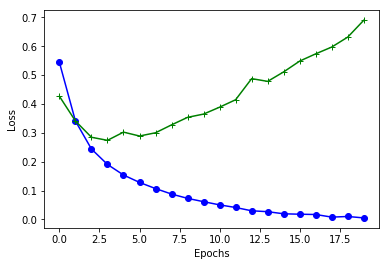

In [49]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(len(loss_values))
# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'b-o')
# g+ is for "green crosses"
plt.plot(epochs, val_loss_values, 'g-+')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Plotando a acurácia dos dados de treinamento e de validação

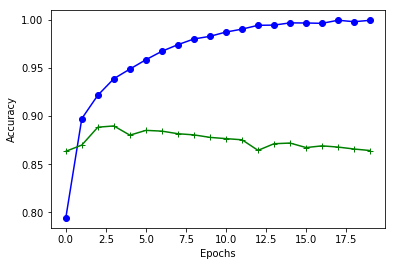

In [50]:
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']
plt.plot(epochs, acc_values, 'b-o')
plt.plot(epochs, val_acc_values, 'g-+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Treinamento final, agora com todos os dados de treinamento disponíveis

Supondo que os dados de testes não são conhecidos na fase de projeto do classificador (treinamento),
o melhor que podemos fazer é utilizar um treinamento final com todos os dados disponíveis e
treinar apenas o número de épocas que deve dar o melhor resultado, baseado no exemplo de treinamento
anterior feito com a validação de dados. Neste caso, vamos treinar por 4 épocas. Note que nesse
caso não existem dados de validação e não temos como medir o quanto há de *overfitting* no treinamento
do classificador.

In [51]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(x_oh_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
25000/25000 [==============================] - 5s - loss: 0.4677 - acc: 0.8150      

## Avaliação do desempenho final

In [52]:
results = model.evaluate(x_oh_test, y_test)
print(results)

24928/25000 [============================>.] - ETA: 0s  

Observe que com esta rede densa de apenas uma camada escondida, com um total de 160 mil parâmetros,
conseguimos uma acurácia de 88%, que é bastante razoável para uma rede simples.
É possível conseguir da ordem de 95% de acurácia utilizando métodos estado-da-arte.

## Gerando predições com dados novos

In [53]:
model.predict(x_oh_test)

array([[ 0.92747164],
       [ 0.65518957],
       [ 0.99919838],
       ..., 
       [ 0.42308313],
       [ 0.00336484],
       [ 0.7332139 ]], dtype=float32)

## Aprendizados

- 